In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(["science", "nature"])
%matplotlib inline

## Load results

In [49]:
all_out = glob("out/**/*.pkl")

In [50]:
all_out = [load_pickle(p) for p in all_out]

In [51]:
all_out

[{'tabpfn_metrics': {'accuracy': 0.6573275862068966,
   'acc_macro': 0.6573275862068966,
   'racc': 0.6573275862068966,
   'kappa': 0.0,
   'confusion_matrix': pycm.ConfusionMatrix(classes: [0, 1]),
   'f1_macro': 0.3966189856957087,
   'f1_micro': 0.6573275862068966,
   'frac_valid': 1.0,
   'all_y_true': (#464) [1,1,1,1,1,1,1,0,0,0...],
   'all_y_pred': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [52]:
extracted_res = []
xgboost_results = []
tabpfn_results = []
dummy_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgb_metrics"]["accuracy"],
        "f1_macro": out["xgb_metrics"]["f1_macro"],
        "f1_micro": out["xgb_metrics"]["f1_micro"],
        "kappa": out["xgb_metrics"]["kappa"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["tabpfn_metrics"]["f1_micro"],
        "kappa": out["tabpfn_metrics"]["kappa"],
    }

    dummy_res = {
        "train_size": out["train_size"],
        "accuracy": out["dummy_metrics"]["accuracy"],
        "f1_macro": out["dummy_metrics"]["f1_macro"],
        "f1_micro": out["dummy_metrics"]["f1_micro"],
        "kappa": out["dummy_metrics"]["kappa"],
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)
    dummy_results.append(dummy_res)

In [53]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)
dummy_res = pd.DataFrame(dummy_results)

In [54]:
grouped_res = res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [55]:
grouped_xgboost_res = xgboost_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [56]:
grouped_dummy_res = dummy_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [57]:
grouped_tabpfn_res = tabpfn_res.groupby(["train_size"]).agg(["mean", "std", "count", sem])

In [58]:
grouped_res.loc[:]

frac_valid                accuracy                f1_macro      \
                 mean std count sem      mean std count sem      mean std   
train_size                                                                  
10                1.0 NaN     1 NaN  0.711538 NaN     1 NaN  0.438824 NaN   
20                1.0 NaN     1 NaN  0.730205 NaN     1 NaN  0.508584 NaN   
50                1.0 NaN     1 NaN  0.729258 NaN     1 NaN  0.556202 NaN   

                      f1_micro                   kappa                
           count sem      mean std count sem      mean std count sem  
train_size                                                            
10             1 NaN  0.711538 NaN     1 NaN -0.016991 NaN     1 NaN  
20             1 NaN  0.730205 NaN     1 NaN  0.079946 NaN     1 NaN  
50             1 NaN  0.729258 NaN     1 NaN  0.150736 NaN     1 NaN

In [59]:
grouped_tabpfn_res

accuracy                f1_macro                f1_micro      \
                mean std count sem      mean std count sem      mean std   
train_size                                                                 
10          0.657328 NaN     1 NaN  0.396619 NaN     1 NaN  0.657328 NaN   
20          0.647815 NaN     1 NaN  0.393136 NaN     1 NaN  0.647815 NaN   
50          0.613718 NaN     1 NaN  0.420309 NaN     1 NaN  0.613718 NaN   

                         kappa                
           count sem      mean std count sem  
train_size                                    
10             1 NaN  0.000000 NaN     1 NaN  
20             1 NaN  0.000000 NaN     1 NaN  
50             1 NaN  0.039846 NaN     1 NaN

In [60]:
grouped_xgboost_res

accuracy                f1_macro                f1_micro      \
                mean std count sem      mean std count sem      mean std   
train_size                                                                 
10          0.562500 NaN     1 NaN  0.400871 NaN     1 NaN  0.562500 NaN   
20          0.629820 NaN     1 NaN  0.392925 NaN     1 NaN  0.629820 NaN   
50          0.602888 NaN     1 NaN  0.400291 NaN     1 NaN  0.602888 NaN   

                         kappa                
           count sem      mean std count sem  
train_size                                    
10             1 NaN -0.133205 NaN     1 NaN  
20             1 NaN -0.031071 NaN     1 NaN  
50             1 NaN  0.011100 NaN     1 NaN

In [61]:
grouped_dummy_res

accuracy                f1_macro                f1_micro      \
                mean std count sem      mean std count sem      mean std   
train_size                                                                 
10          0.657328 NaN     1 NaN  0.396619 NaN     1 NaN  0.657328 NaN   
20          0.647815 NaN     1 NaN  0.393136 NaN     1 NaN  0.647815 NaN   
50          0.602888 NaN     1 NaN  0.376126 NaN     1 NaN  0.602888 NaN   

                     kappa                
           count sem  mean std count sem  
train_size                                
10             1 NaN   0.0 NaN     1 NaN  
20             1 NaN   0.0 NaN     1 NaN  
50             1 NaN   0.0 NaN     1 NaN

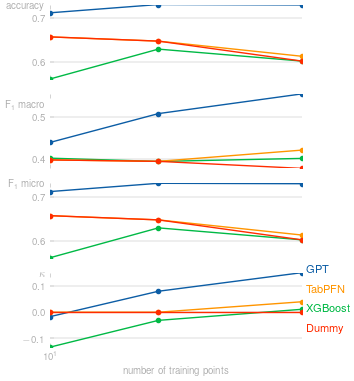

In [62]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[ :].index,
            grouped_res.loc[:][metric]["mean"] - grouped_res.loc[ :][metric]["sem"],
            grouped_res.loc[ :][metric]["mean"] + grouped_res.loc[ :][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[ :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[ :].index,
            grouped_xgboost_res.loc[:][metric]["mean"]
            - grouped_xgboost_res.loc[ :][metric]["sem"],
            grouped_xgboost_res.loc[:][metric]["mean"]
            + grouped_xgboost_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[ :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[ :].index,
            grouped_tabpfn_res.loc[:][metric]["mean"]
            - grouped_tabpfn_res.loc[ :][metric]["sem"],
            grouped_tabpfn_res.loc[ :][metric]["mean"]
            + grouped_tabpfn_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

        ax[i].plot(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[ :][metric]["mean"],
            marker="o",
            label="Dummy",
        )
        ax[i].fill_between(
            grouped_dummy_res.loc[ :].index,
            grouped_dummy_res.loc[:][metric]["mean"]
            - grouped_dummy_res.loc[ :][metric]["sem"],
            grouped_dummy_res.loc[ :][metric]["mean"]
            + grouped_dummy_res.loc[:][metric]["sem"],
            alpha=0.2,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    ax[0].set_xscale("log")

    fig.savefig("mof_synthesizability-classification_results_2.pdf", bbox_inches="tight")

In [63]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

In [64]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

KeyError: 2

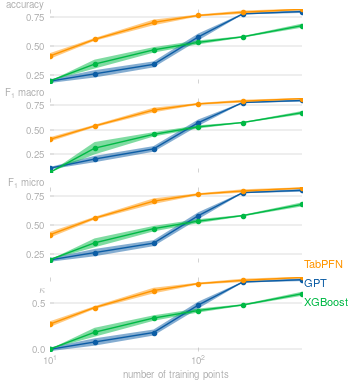

In [12]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(
        4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
    )

    # plot the binary case, i.e. num_classes = 2

    for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
        ax[i].plot(
            grouped_res.loc[5, :].index,
            grouped_res.loc[5, :][metric]["mean"],
            marker="o",
            label="GPT",
        )
        ax[i].fill_between(
            grouped_res.loc[5, :].index,
            grouped_res.loc[5, :][metric]["mean"] - grouped_res.loc[5, :][metric]["sem"],
            grouped_res.loc[5, :][metric]["mean"] + grouped_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"],
            marker="o",
            label="XGBoost",
        )
        ax[i].fill_between(
            grouped_xgboost_res.loc[5, :].index,
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            - grouped_xgboost_res.loc[5, :][metric]["sem"],
            grouped_xgboost_res.loc[5, :][metric]["mean"]
            + grouped_xgboost_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

        ax[i].plot(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"],
            marker="o",
            label="TabPFN",
        )
        ax[i].fill_between(
            grouped_tabpfn_res.loc[5, :].index,
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            - grouped_tabpfn_res.loc[5, :][metric]["sem"],
            grouped_tabpfn_res.loc[5, :][metric]["mean"]
            + grouped_tabpfn_res.loc[5, :][metric]["sem"],
            alpha=0.5,
        )

    matplotx.line_labels(ax[-1], fontsize=8)
    matplotx.ylabel_top("accuracy", ax=ax[0])
    matplotx.ylabel_top(r"F$_{1}$ macro", ax=ax[1])
    matplotx.ylabel_top(r"F$_{1}$ micro", ax=ax[2])
    matplotx.ylabel_top(r"$\kappa$", ax=ax[3])
    ax[-1].set_xlabel("number of training points", labelpad=4)

    ax[0].set_xscale("log")
    fig.savefig("polymner-classification_results_5.pdf", bbox_inches="tight")